In [110]:
import os
import numpy as np
import sklearn.decomposition as decomp
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
import pandas


%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}



set some output options

In [111]:
np.set_printoptions(threshold=np.nan, linewidth=10000000000)
pandas.set_option('display.height', 1000)
pandas.set_option('display.max_rows', 500)
pandas.set_option('display.max_columns', 500)
pandas.set_option('display.width', 1000)


height has been deprecated.



function for flexible data frame loading

In [112]:
def get_data_from_tsv(feature_file, x_fields, y_field, x_filter=None, seed=0, as_np_array=False, scale=False, shuffle=False, train_portion=0.6, test_portion=0.2):

    # Load the dataset
    my_data = pandas.read_csv(feature_file)


    # Drop missing values
    print(my_data.shape)
    my_data = my_data.dropna()
    my_data = my_data.reset_index(drop=True)
    print(my_data.shape)
    
    # Filter responses if len(x_filter) > 0
    if not x_filter == None:
        for ff in x_filter:
            my_data = my_data.loc[my_data[ff[0]].isin(ff[1:])]
            print("filtering %s by " % ff[0], ff[1:], "num datapoints left: ", len(my_data))
        my_data = my_data.reset_index(drop=True)
    labels = my_data['word']
        
    # turn frequencies into log frequencies
    if 'freq' in x_fields or my_data.columns.get_loc('freq') in x_fields:
        idx = my_data.columns.get_loc('freq')
        my_data.iloc[:,idx] = np.log(my_data.iloc[:,idx])
        my_data=my_data.rename(columns = {'freq':'log_freq'})

    # turn lengths into log lengths
    if 'length' in x_fields or my_data.columns.get_loc('length') in x_fields:
        idx = my_data.columns.get_loc('length')
        my_data.iloc[:,idx] = np.log(my_data.iloc[:,idx])
        my_data=my_data.rename(columns = {'length':'log_length'})
 
    # Choose the coefficients
    if type(x_fields[0]) == str:
        x_fields.append(y_field)
        my_data = my_data[x_fields]
    else:
        x_fields.append(my_data.columns.get_loc(y_field))
        my_data = my_data.iloc[:,x_fields]
    del x_fields[-1]
    
    # Split the data into training/testing sets
    x_train, y_train, x_dev, y_dev, x_test, y_test = train_validate_test_split(my_data, 
                                                                               y_field,
                                                                               train_percent=train_portion,
                                                                               validate_percent=test_portion,
                                                                               seed=seed,
                                                                               shuffle=shuffle)

    if scale:
        x_train = pandas.DataFrame(preprocessing.scale(x_train), columns=x_train.columns, index=x_train.index)
        x_dev   = pandas.DataFrame(preprocessing.scale(x_dev)  , columns=x_dev.columns, index=x_dev.index)
        x_test  = pandas.DataFrame(preprocessing.scale(x_test) , columns=x_test.columns, index=x_test.index)
        y_train = pandas.DataFrame(preprocessing.scale(y_train), columns=y_train.columns, index=y_train.index)
        y_dev   = pandas.DataFrame(preprocessing.scale(y_dev)  , columns=y_dev.columns, index=y_dev.index)
        y_test  = pandas.DataFrame(preprocessing.scale(y_test) , columns=y_test.columns, index=y_test.index)

    
    if as_np_array:
        x_train = np.array(x_train).astype(np.float)
        y_train = np.array(y_train).astype(np.float)
        x_dev   = np.array(x_dev).astype(np.float)
        y_dev   = np.array(y_dev).astype(np.float)
        x_test  = np.array(x_test).astype(np.float)
        y_test  = np.array(y_test).astype(np.float)
        
    return x_train, y_train, x_dev, y_dev, x_test, y_test, labels




function for train / dev / test splitting

In [113]:
def train_validate_test_split(df, y, train_percent=.6, validate_percent=.2, seed=0, shuffle=True):
    np.random.seed(seed)
    
    if shuffle:
        perm = np.random.permutation(df.index)
    else:
        perm = df.index

    train_end    = int(train_percent * len(df))
    validate_end = int(validate_percent * len(df)) + train_end

    
    x_train        = df.iloc[perm[:train_end]]
    x_validate     = df.iloc[perm[train_end:validate_end]]
    x_test         = df.iloc[perm[validate_end:]]
        
    y_train    = x_train[y]
    y_validate = x_validate[y]
    y_test     = x_test[y]
    
    x_train = x_train.drop(y, axis=1)
    x_validate = x_validate.drop(y, axis=1)
    x_test = x_test.drop(y, axis=1)

    return x_train, y_train, x_validate, y_validate, x_test, y_test




- Load the data (both Brent and Providence)
- Define set of x features (predictors
- Define y variable

In [114]:
corpus    = "Brent"
providence_data_file = os.path.join("data/brent_avg_prosody.csv")

brent_data_file      = os.path.join("data/providence_avg_prosody.csv")

# define x-fields (column IDs) to keep at 1    = word itself
#                                         2    = pos
#                                         3    = length (letters)
#                                         4    = frequency
#                                         5-93 = egemaps prosody features
features  = list(range(1,93))

# define name (col header) of y-variable in data file
y         = 'y'

# load data, x-fields, y-field, train/dev/test split from input file
providence_x_train, providence_y_train, _, _, _, _, labels = get_data_from_tsv(providence_data_file, 
                                                                      x_fields=features, 
                                                                      y_field=y, 
                                                                      train_portion=1.0,
                                                                      shuffle=False)

brent_x_train, brent_y_train, _, _, _, _, labels = get_data_from_tsv(brent_data_file, 
                                                                      x_fields=features, 
                                                                      y_field=y, 
                                                                      train_portion=1.0,
                                                                      shuffle=False)

if corpus == "Providence":
    x_train = providence_x_train
    y_train = providence_y_train
elif corpus == "Brent":
    x_train = brent_x_train
    y_train = brent_y_train

(364, 93)
(364, 93)
(370, 93)
(370, 93)


Scale all numeric features

In [115]:
print("-> unscaled\n", x_train.iloc[:3,:5])

x_train[x_train.columns[2:]] = pandas.DataFrame(preprocessing.scale(x_train[x_train.columns[2:]]), 
                                                columns=x_train.columns[2:], 
                                                index=x_train.index)


print("-> scaled\n", x_train.iloc[:3,:5])

-> unscaled
        word             pos  log_length  log_freq  F0semitoneFrom27.5Hz_sma3nz_amean
0  airplane           nouns    2.079442  4.330733                          33.140194
1       all  function_words    1.098612  7.913887                          32.802185
2      gone      adjectives    1.386294  4.969813                          34.666500
-> scaled
        word             pos  log_length  log_freq  F0semitoneFrom27.5Hz_sma3nz_amean
0  airplane           nouns    1.764268 -0.620002                           0.152633
1       all  function_words   -1.257305  1.813862                           0.009108
2      gone      adjectives   -0.371063 -0.185906                           0.800735


/usr/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Features with abs(correlation) > 0.9 
0.926199558486 --- 2 --- 4 --- F0semitoneFrom27.5Hz_sma3nz_amean --- F0semitoneFrom27.5Hz_sma3nz_percentile20.0
0.992124353246 --- 2 --- 5 --- F0semitoneFrom27.5Hz_sma3nz_amean --- F0semitoneFrom27.5Hz_sma3nz_percentile50.0
0.952911988174 --- 2 --- 6 --- F0semitoneFrom27.5Hz_sma3nz_amean --- F0semitoneFrom27.5Hz_sma3nz_percentile80.0
0.972103430293 --- 3 --- 7 --- F0semitoneFrom27.5Hz_sma3nz_stddevNorm --- F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2
0.926199558486 --- 4 --- 2 --- F0semitoneFrom27.5Hz_sma3nz_percentile20.0 --- F0semitoneFrom27.5Hz_sma3nz_amean
0.992124353246 --- 5 --- 2 --- F0semitoneFrom27.5Hz_sma3nz_percentile50.0 --- F0semitoneFrom27.5Hz_sma3nz_amean
0.955779412366 --- 5 --- 6 --- F0semitoneFrom27.5Hz_sma3nz_percentile50.0 --- F0semitoneFrom27.5Hz_sma3nz_percentile80.0
0.952911988174 --- 6 --- 2 --- F0semitoneFrom27.5Hz_sma3nz_percentile80.0 --- F0semitoneFrom27.5Hz_sma3nz_amean
0.955779412366 --- 6 --- 5 --- F0semitoneFrom27.5Hz_sm

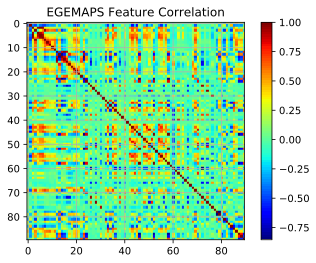

In [116]:
# compute and plot correlations


# if you like select a subset of features like this
# featureset = ['freq', 
#                'length']
#               'mfcc2_sma3_amean',
#               'mfcc4V_sma3nz_amean', 
#               'MeanVoicedSegmentLengthSec']
# x_selected = x_train[featureset].copy()
# print(x_selected.head(5))

# otherwise take the whole training set
x_selected  = x_train

# get correlation matrix
correlations= x_selected.corr()

# do the plotting
fig      = plt.figure()
ax1      = fig.add_subplot(111)
ax1.grid(True)
colormap = cm.get_cmap('jet', len(correlations.columns))
cax      = ax1.imshow(correlations, 
                      interpolation="nearest", 
                      cmap=colormap)
plt.title('EGEMAPS Feature Correlation')
labels=[str(i) for i in range(len(correlations.columns))]
fig.colorbar(cax)
fig.show()

# print features values with correlation higher than some threshold
threshold = 0.9
print("Features with abs(correlation) > 0.9 ")
for row in range(correlations.shape[0]):
    for col in range(correlations.shape[1]):
        val = correlations.iloc[row, col]
        if val != 1.0 and (val > threshold or val < (-threshold)):
            print(" --- ".join([str(val), 
                                str(row),
                                str(col),
                                correlations.index[row], 
                                correlations.columns[col]]))





Run PCA on the full feature set and check if words cluster by their part of speech in the resulting 2-d space (spanning the first two principle components)

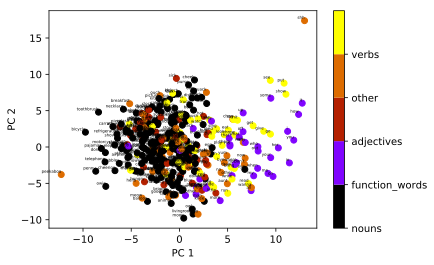

In [117]:
ncomponents = 10

# you can select features of interest in this list and change iloc to loc in pca.fit and pca.transform below
# good_features = ['loudness_sma3_meanRisingSlope', 
#                  'spectralFluxV_sma3nz_stddevNorm',
#                  'mfcc2_sma3_amean',
#                  'mfcc4V_sma3nz_amean', 
#                  'MeanVoicedSegmentLengthSec']

# good_features = ['freq','equivalentSoundLevel_dBp']


pca     = decomp.PCA(n_components=ncomponents)
raw_pca = pca.fit(np.array(x_train.iloc[:,3:93]).astype(np.float))
x_pca   = raw_pca.transform(x_train.iloc[:,3:93])

# we want to check if natural data groupings can be recovered
# in the space spanned by the first two principle components
groups        = x_train['pos']

# get individual POS values
group_values  = [str(i) for i in groups.unique()]

# map pos values to IDs
posIDs         = groups.factorize()[0]

# we want to label all data points in the plot with their word string
labels = np.array(x_train['word'])


# plot first two principle components
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

colormap = plt.get_cmap('gnuplot', len(group_values))

pc1 = x_pca[:,0]
pc2 = x_pca[:,1]

p = ax.scatter(pc1, pc2, c=posIDs, cmap=colormap)#, ) #, 

# add color bar
cb = plt.colorbar(p)
loc = np.arange(0,max(posIDs),max(posIDs)/float(len(group_values)))
cb.set_ticks(loc)
cb.set_ticklabels(group_values)

for label, x, y in zip(labels, pc1, pc2):
    if y==np.amax(y) or x==np.amax(x) :
        plt.annotate(label,
                     fontsize=4,
                     xy=(x, y), xytext=(0, 1),
                     textcoords='offset points', ha='right', va='bottom')


Compute feature correlation between two data samples (Brent vs Providence corpus)

First, get word lists

In [118]:
brent_words = brent_x_train['word'].tolist()
provi_words = providence_x_train['word'].tolist()

difference = [w for w in brent_words if w not in provi_words]

print("%d words in Brent" %len(brent_words))
print("%d words in Providence" % len(provi_words))
print("Corpus coverage difference: ", difference)

370 words in Brent
364 words in Providence
Corpus coverage difference:  ['bathroom', 'bathtub', 'bedroom', 'goodnight', 'livingroom', 'potty']


Then, drop all words that are not in both lists

In [119]:
provi=providence_x_train[providence_x_train['word'].isin(brent_words)]
provi=provi.reset_index(drop=True)

brent=brent_x_train[brent_x_train['word'].isin(provi_words)]
brent=brent.reset_index(drop=True)

print("\nFeature correlations between two data samples (Brent corpus and Providence corpus) \n")
print(brent.corrwith(provi, drop=True))




Feature correlations between two data samples (Brent corpus and Providence corpus) 

log_length                                        1.000000
log_freq                                          0.853005
F0semitoneFrom27.5Hz_sma3nz_amean                 0.575126
F0semitoneFrom27.5Hz_sma3nz_stddevNorm            0.587623
F0semitoneFrom27.5Hz_sma3nz_percentile20.0        0.466053
F0semitoneFrom27.5Hz_sma3nz_percentile50.0        0.567050
F0semitoneFrom27.5Hz_sma3nz_percentile80.0        0.663301
F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2          0.638712
F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope       0.304630
F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope     0.072898
F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope      0.120024
F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope    0.356427
loudness_sma3_amean                               0.435408
loudness_sma3_stddevNorm                          0.836723
loudness_sma3_percentile20.0                      0.607009
loudness_sma3_percentile50.0 